# Import necessary python packages

In [1]:
import os
import shutil
import subprocess

from rdkit.Chem import AllChem
from rdkit.Chem import rdChemReactions
import py3Dmol

from importlib_resources import files

# Load packages from silc

In [2]:
import silc.util as util
from silc.build_molecule import binding_molecule

In [3]:
def replaceDummy(smiles, new=None):
    if new is None:
        return smiles
    else:
        if smiles.count("*") == 1:
            return smiles.replace("*", new[0])
        elif smiles.count("*") == 2:
            loc = smiles.find("[1*]")
            smiles = smiles[:loc+2] + new[0] + smiles[loc+3:]
            loc = smiles.find("[2*]")
            smiles = smiles[:loc+2] + new[1] + smiles[loc+3:]
            return smiles

# Some example cores

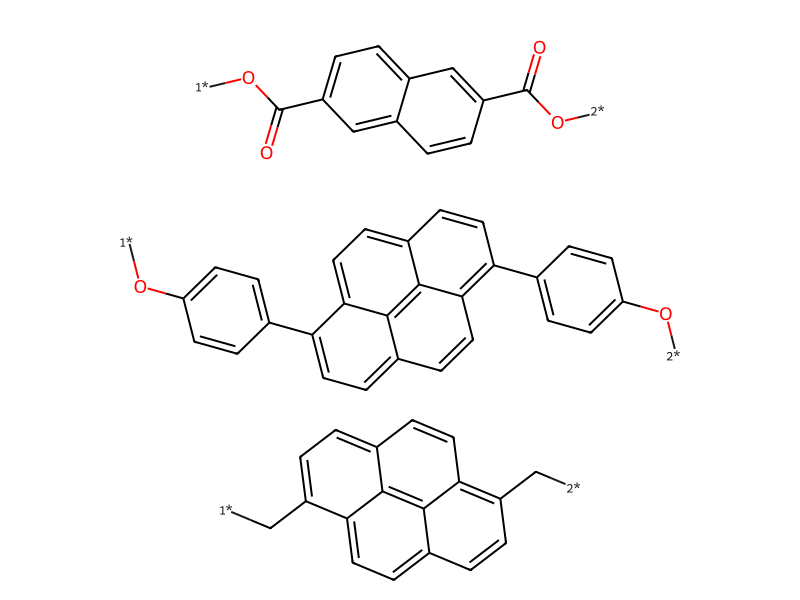

In [4]:
core1_smiles = "[1*]OC(=O)c1ccc2cc(ccc2c1)C(=O)O[2*]"
core2_smiles = "[1*]Oc6ccc(c2ccc3ccc5c(c1ccc(O[2*])cc1)ccc4ccc2c3c45)cc6"
core3_smiles = "[1*]C(c2ccc3ccc5c(C[2*])ccc4ccc2c3c45)"

core1 = AllChem.MolFromSmiles(replaceDummy(core1_smiles))
core2 = AllChem.MolFromSmiles(replaceDummy(core2_smiles))
core3 = AllChem.MolFromSmiles(replaceDummy(core3_smiles))

img = AllChem.Draw.MolsToGridImage([core1, core2, core3], molsPerRow=1, subImgSize=(800, 200))
img

# Some example tails

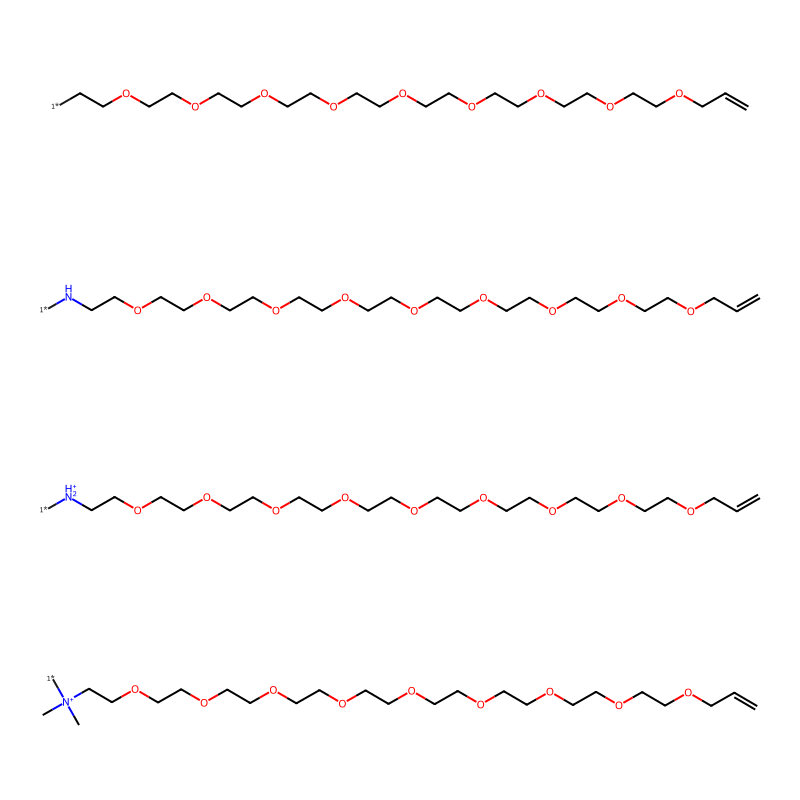

In [5]:
tail1_smiles = lambda nEO: "C=CC" + "OCC"*nEO + "[1*]"
tail2_smiles = lambda nEO: "C=CC" + "OCC"*nEO + "N" + "[1*]"
tail3_smiles = lambda nEO: "C=CC" + "OCC"*nEO + "[NH2+]" + "[1*]"
tail4_smiles = lambda nEO: "C=CC" + "OCC"*nEO + "[N+](C)(C)" + "[1*]"

nEO = 9
tail1 = AllChem.MolFromSmiles(replaceDummy(tail1_smiles(nEO)))
tail2 = AllChem.MolFromSmiles(replaceDummy(tail2_smiles(nEO)))
tail3 = AllChem.MolFromSmiles(replaceDummy(tail3_smiles(nEO)))
tail4 = AllChem.MolFromSmiles(replaceDummy(tail4_smiles(nEO)))

img = AllChem.Draw.MolsToGridImage([tail1, tail2, tail3, tail4], molsPerRow=1, subImgSize=(800, 200))
img

# Some example bridges

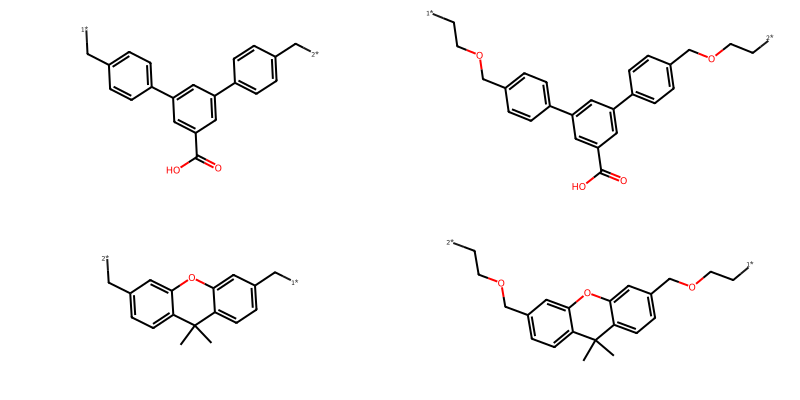

In [6]:
bridge1_smiles = lambda nEO: "O=C(O)c1cc(c2ccc(C" + "OCC" * nEO + "[1*])cc2)cc(c2ccc(C" + "OCC" * nEO + "[2*])cc2)c1"
bridge2_smiles = lambda nEO: "CC1(C)c2ccc(C" + "OCC" * nEO + "[1*])cc2Oc2cc(C" + "OCC" * nEO + "[2*])ccc21"

nEO_B = 0
bridge1_0 = AllChem.MolFromSmiles(replaceDummy(bridge1_smiles(nEO_B)))
bridge2_0 = AllChem.MolFromSmiles(replaceDummy(bridge2_smiles(nEO_B)))
nEO_B = 1
bridge1_1 = AllChem.MolFromSmiles(replaceDummy(bridge1_smiles(nEO_B)))
bridge2_1 = AllChem.MolFromSmiles(replaceDummy(bridge2_smiles(nEO_B)))
img = AllChem.Draw.MolsToGridImage([bridge1_0, bridge1_1, bridge2_0, bridge2_1], molsPerRow=2, subImgSize=(400, 200))
img

# Create ditopic binding motifs by "reaction" in RDKit
Here we demonstrate the formation of a ditopic binding motif

We first define reaction rule

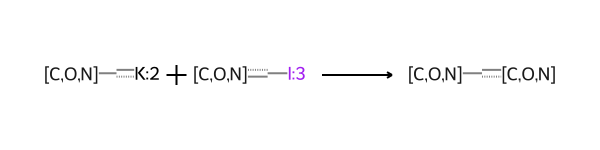

In [7]:
rxn = rdChemReactions.ReactionFromSmarts("[C,O,N:1][K:2].[I:3][C,O,N:4]>>[C,O,N:1][C,O,N:4]")
rxn

Create a reactant, where we change the dummy atom to I for reactions

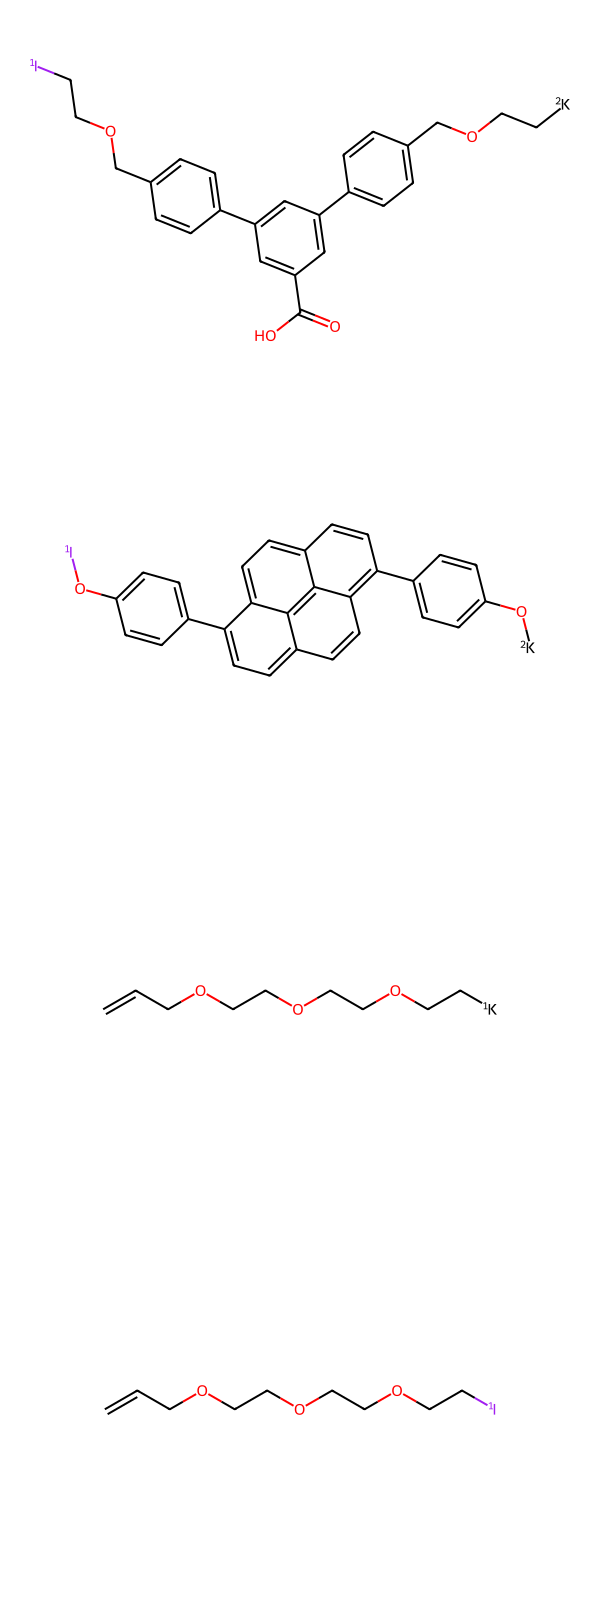

In [8]:
A = AllChem.MolFromSmiles(replaceDummy(bridge1_smiles(1), new=["I", "K"]))
B = AllChem.MolFromSmiles(replaceDummy(core2_smiles, new=["I", "K"]))
Ca = AllChem.MolFromSmiles(replaceDummy(tail1_smiles(3), new=["K"]))
Cb = AllChem.MolFromSmiles(replaceDummy(tail1_smiles(3), new=["I"]))
img = AllChem.Draw.MolsToGridImage([A, B, Ca, Cb], molsPerRow=1, subImgSize=(600, 400))
img

# Create binding motif

Reaction takes two steps: \
(1) Ca(tail, first) + B(core) -> CaB \
(2) CaB + Cb (tail, second) -> CaBCb

[00:46:34] mapped atoms in the reactants were not mapped in the products.
  unmapped numbers are: 2 3 


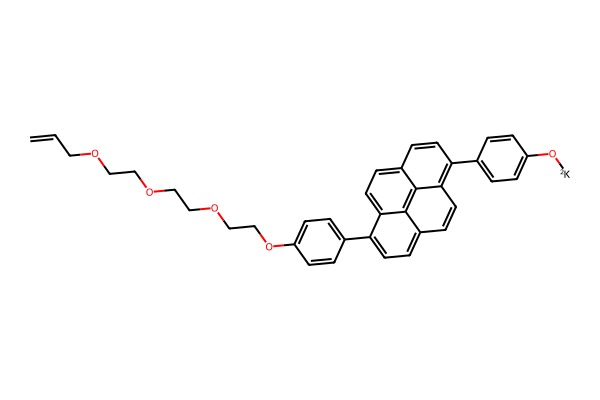

In [9]:
reacts = (Ca, B)
products = rxn.RunReactants(reacts)
CaB = products[0][0]
AllChem.SanitizeMol(CaB)
img = AllChem.Draw.MolsToGridImage([CaB], molsPerRow=1, subImgSize=(600, 400))
img

# Create ditopic molecule

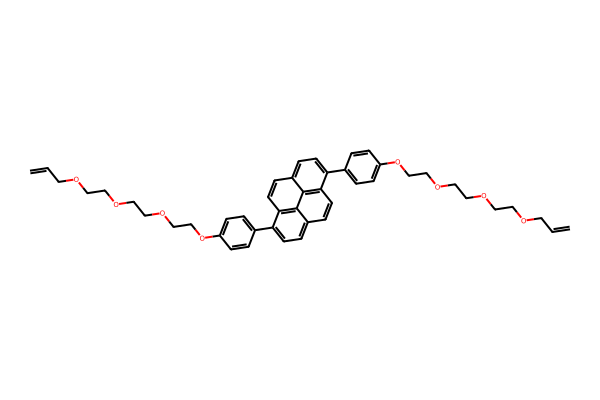

In [10]:
reacts = (CaB, Cb)
products = rxn.RunReactants(reacts)
CaBCb = products[0][0]
AllChem.SanitizeMol(CaBCb)
img = AllChem.Draw.MolsToGridImage([CaBCb], molsPerRow=1, subImgSize=(600, 400))
img

Reaction takes foure steps: \
(1) Ca(tail, first) + B(core) -> CaB \
(2) CaB + A (bridge) -> CaBA \
(3) CaBA + B -> CaBAB \
(4) CaBAB + Cb (tail, second) -> CaBABCb

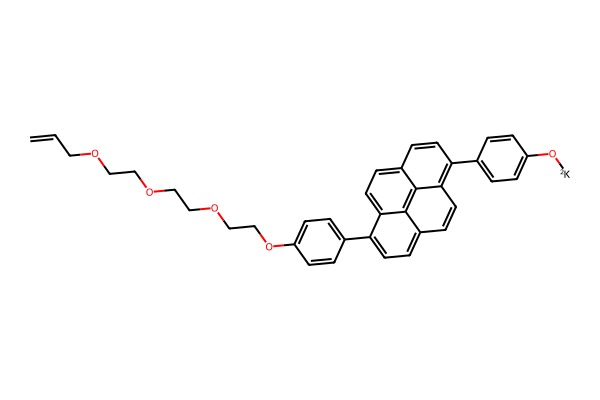

In [11]:
reacts = (Ca, B)
products = rxn.RunReactants(reacts)
CaB = products[0][0]
AllChem.SanitizeMol(CaB)
img = AllChem.Draw.MolsToGridImage([CaB], molsPerRow=1, subImgSize=(600, 400))
img

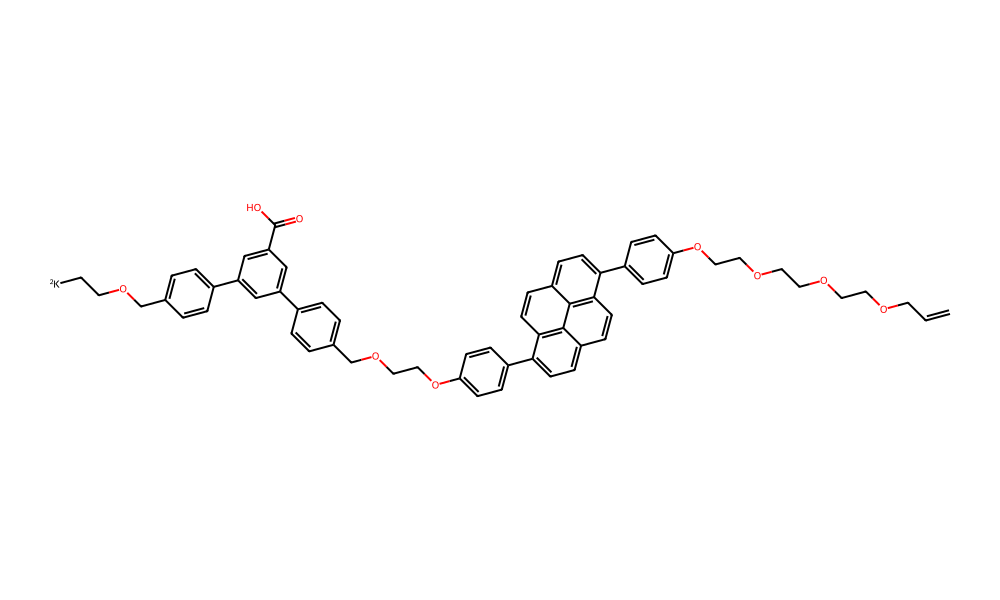

In [12]:
reacts = (CaB, A)
products = rxn.RunReactants(reacts)
CaBA = products[0][0]
AllChem.SanitizeMol(CaBA)
img = AllChem.Draw.MolsToGridImage([CaBA], molsPerRow=1, subImgSize=(1000, 600))
img

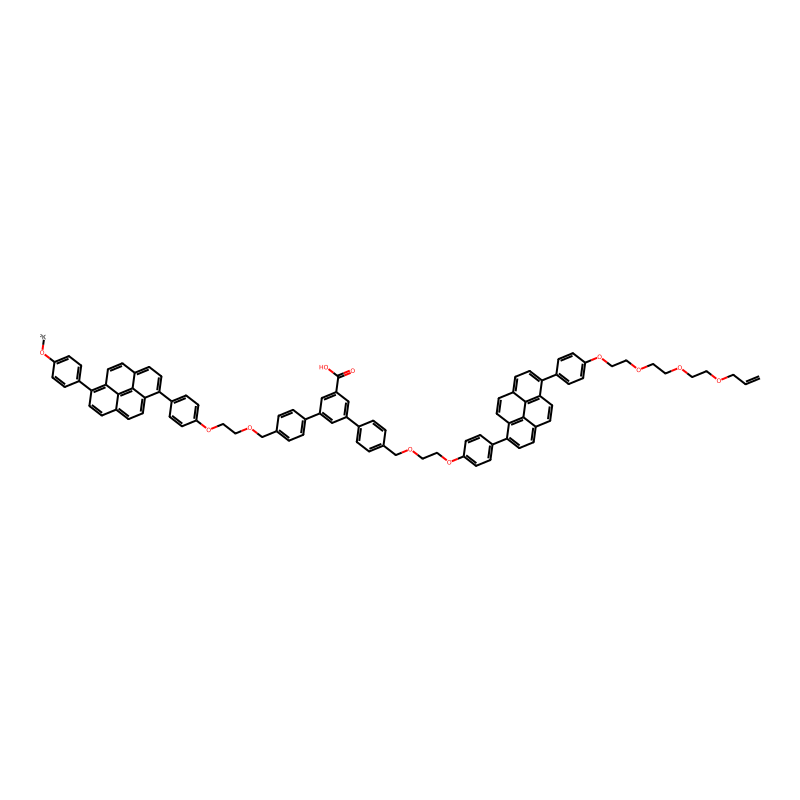

In [13]:
reacts = (CaBA, B)
products = rxn.RunReactants(reacts)
CaBAB = products[0][0]
AllChem.SanitizeMol(CaBAB)
img = AllChem.Draw.MolsToGridImage([CaBAB], molsPerRow=1, subImgSize=(800, 800))
img

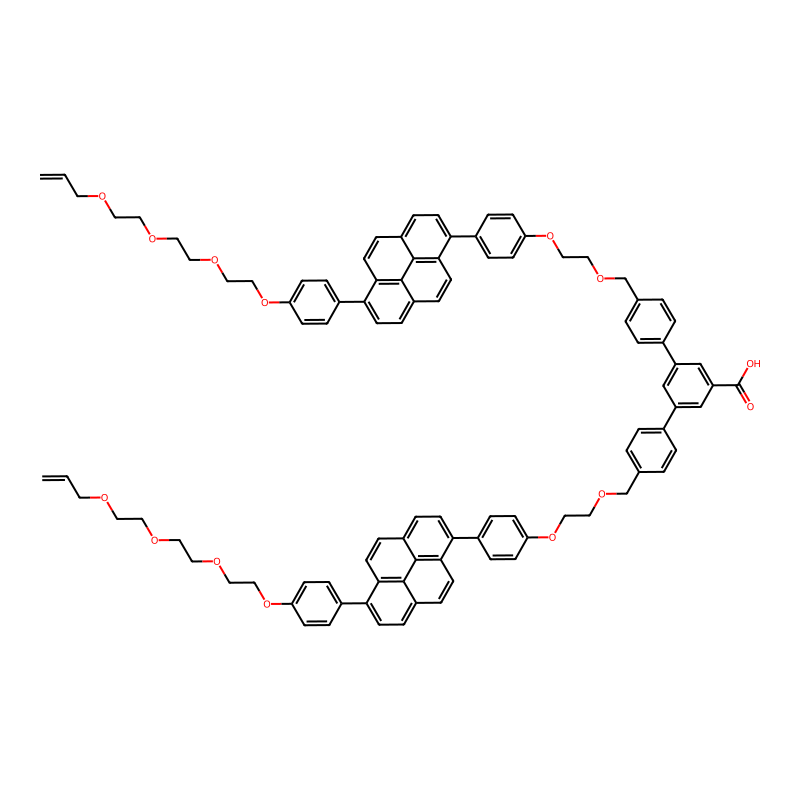

In [14]:
reacts = (CaBAB, Cb)
products = rxn.RunReactants(reacts)
CaBABCb = products[0][0]
AllChem.SanitizeMol(CaBABCb)
img = AllChem.Draw.MolsToGridImage([CaBABCb], molsPerRow=1, subImgSize=(800, 800))
img

In [15]:
def reaction(reactants):
    ### define reaction
    ### K is used as the tail dummy atom in the head molecule, I is used as the head dummy atom in the tail molecule
    rxn = rdChemReactions.ReactionFromSmarts("[C,O,N:1][K:2].[I:3][C,O,N:4]>>[C,O,N:1][C,O,N:4]")
    prod = reactants[0]
    if len(reactants) >= 2:
        for i in range(len(reactants)-1):
            reacts = (prod, reactants[i+1])
            products = rxn.RunReactants(reacts)
            prod = products[0][0]
            AllChem.SanitizeMol(prod)
    return prod

0


[00:46:34] mapped atoms in the reactants were not mapped in the products.
  unmapped numbers are: 2 3 


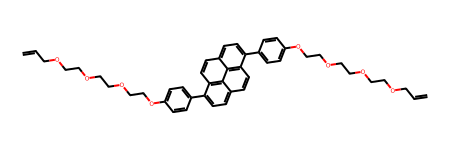

In [16]:
prod = reaction([Ca, B, Cb])
smiles = AllChem.MolToSmiles(prod, canonical=True)
fc = AllChem.GetFormalCharge(AllChem.MolFromSmiles(smiles))
print(fc)
prod

[00:46:34] mapped atoms in the reactants were not mapped in the products.
  unmapped numbers are: 2 3 


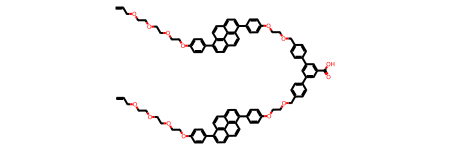

In [17]:
reaction([Ca, B, A, B, Cb])

# Build residue files for molecular fragments

In [18]:
dm = binding_molecule()
dm.set_core_smiles(core2_smiles, ["C", "C"])
dm.set_tail_smiles(tail1_smiles(3), ["O"])
dm.set_bridge_smiles(bridge1_smiles(1), ["O", "O"])
dm.set_core_num_confs_for_charge(1)
dm.set_tail_num_confs_for_charge(5)
dm.set_bridge_num_confs_for_charge(5)
dm.set_work_path("build_molecules")
dm.clear_work_path()    # this will remove the work_path, it is only for building new molecules from new segments

# Build a binding motif (i.e., tail-core-tail)

In [19]:
dm.create_binding_motif()

Find residue in database at /home/heyi/env/py38/lib/python3.8/site-packages/silc/data/residue/core/1
Find residue in database at /home/heyi/env/py38/lib/python3.8/site-packages/silc/data/residue/tail/1
-I: Adding /home/heyi/env/py38/dat/leap/prep to search path.
-I: Adding /home/heyi/env/py38/dat/leap/lib to search path.
-I: Adding /home/heyi/env/py38/dat/leap/parm to search path.
-I: Adding /home/heyi/env/py38/dat/leap/cmd to search path.
-f: Source tleap_motif.in.

Welcome to LEaP!
(no leaprc in search path)
Sourcing: ./tleap_motif.in
----- Source: /home/heyi/env/py38/dat/leap/cmd/leaprc.gaff2
----- Source of /home/heyi/env/py38/dat/leap/cmd/leaprc.gaff2 done
Log file: ./leap.log
Loading parameters: /home/heyi/env/py38/dat/leap/parm/gaff2.dat
Reading title:
AMBER General Force Field for organic molecules (Version 2.2.20, March 2021)
Log file: ./leap_motif.log
Loading Prep file: ./core/molecule_head.prepi
Loading Prep file: ./core/molecule_tail.prepi
Loading Prep file: ./tail/molecule

[00:46:34] mapped atoms in the reactants were not mapped in the products.
  unmapped numbers are: 2 3 


In [20]:
motif = util.read_amber_mol2(os.path.join("build_molecules","motif.mol2"))
motif_block = AllChem.MolToMolBlock(motif)
viewer = py3Dmol.view(width=1000, height=500)
viewer.addModel(motif_block, 'mol')
viewer.setStyle({}, {'stick': {}})
viewer.zoomTo()
viewer.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

# Build a ditopic molecule (i.e., tail-core-bridge-core-tail)

In [21]:
dm.create_ditopic_molecule()

Residue exists in work path at /home/heyi/Projects/Interlock/silc/tutorial/build_molecules/core
Residue exists in work path at /home/heyi/Projects/Interlock/silc/tutorial/build_molecules/tail
Find residue in database at /home/heyi/env/py38/lib/python3.8/site-packages/silc/data/residue/bridge/1
-I: Adding /home/heyi/env/py38/dat/leap/prep to search path.
-I: Adding /home/heyi/env/py38/dat/leap/lib to search path.
-I: Adding /home/heyi/env/py38/dat/leap/parm to search path.
-I: Adding /home/heyi/env/py38/dat/leap/cmd to search path.
-f: Source tleap_ditopic.in.

Welcome to LEaP!
(no leaprc in search path)
Sourcing: ./tleap_ditopic.in
----- Source: /home/heyi/env/py38/dat/leap/cmd/leaprc.gaff2
----- Source of /home/heyi/env/py38/dat/leap/cmd/leaprc.gaff2 done
Log file: ./leap.log
Loading parameters: /home/heyi/env/py38/dat/leap/parm/gaff2.dat
Reading title:
AMBER General Force Field for organic molecules (Version 2.2.20, March 2021)
Log file: ./leap_ditopic.log
Loading Prep file: ./core/m

[00:46:34] mapped atoms in the reactants were not mapped in the products.
  unmapped numbers are: 2 3 


In [22]:
ditopic = util.read_amber_mol2(os.path.join("build_molecules","ditopic.mol2"))
ditopic_block = AllChem.MolToMolBlock(ditopic)
viewer = py3Dmol.view(width=1000, height=500)
viewer.addModel(ditopic_block, 'mol')
viewer.setStyle({}, {'stick': {}})
viewer.zoomTo()
viewer.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol